In [1]:
import numpy as np
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
from scipy.fftpack import fft, ifft, fftshift
from scipy.signal import find_peaks
from ipywidgets import interact, FloatSlider
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib widget

# Exercise 5: **Antenna Directivity**

*Visualize a polar-plot of the far-ﬁeld power-pattern of an antenna-array consisting of N omni-
directional antennas positioned on a straight line. Employ a method that allows you to control
the directivity of your antenna-array. (Check also lessons learned from Section 2.7!) Explain how
such a (passive) microwave sensing system can determine the direction of incoming signals.*

## 5.1 How can the design of a microwave antenna control its directivity?

As seen from the double slit experiment above, combining two point sources results in an interference pattern in the far field. This intensity distribution depends on the distance of the detector from the source-plane, the wavelength, 'point source width' (= slit width) and the distance between the two point sources (= slits). The resulting interferene patterns above were calculated based on an assumption: that all point sources were in phase, i.e. they emitted temporally coherent emws. Thus, the maximum of the interference pattern was found right in the middle between the two point sources. 


If the two point sources were not in phase, the maximum of the interference pattern would be shifted. By varying the amount of point sources, their distances and the phase with which each of them emits emws, the resulting interference pattern can be controlled. This is the basic principle of a phase array antenna.


**Note:**
*Other paramenters controlling this pattern would be the wavelentgh $\lambda_i$ and amplitude $A_{0,i}$ of point source $i$. We will assume that each point source emits radiation of same wavelength, polarization and amplitude.*

Assume $m=N$ emitters, evenly spaced at distances $d$ in a linear array of total length $l = (N-1)d$. Each emitter emtis a spherical wave: $\vec{E} \propto \dfrac{\exp\left(i\vec{k}\vec{r}\right)}{4\pi r}$. This wave corresponds to an **Array Factor AF** of 1. If in the far field the waves emitted by two neighboring emitter $m$ and $m+1$ are probed at an angle $\theta$ relative to the array ($\theta = 0 \rightarrow$ parrallel to array, $\theta = 0.5\pi \rightarrow$ perpendicular), the phase difference is $\phi = kd\cos\theta$. The overall resultign field is the superposition of all $N-1$ fields emitted by the $N-1$ emitters and the array factor thus is given as:

$AF = \sum_{m=0}^{N-1}\exp\left(im\psi\right), \psi = kd\cos\theta$

Multiplying both sides of the above equation, let's call it eq.1, by $\exp\left(i\psi\right)$ (calling the result eq.2) and then subtracting eq.2 from eq.1 yields:

$AF\left(1-\exp\left(i\psi\right)\right) = 1-\exp\left(i\psi N\right)$

Rearranging this expression yields:

$ AF = \exp\left(i\dfrac{\psi}{2}\left(N-1\right)\right) \cdot \dfrac{\sin\left(N\dfrac{\psi}{2}\right)}{\sin\left(\dfrac{\psi}{2}\right)}$

To normalize, the maximum of $AF$ needs to be found. To do so, $AF$ is expressed as a series expansion at $\psi = 0$ and only the first term is kept:

$ AF = N + O\left(\psi\right)$

Thus, the maximum of AF is $N$.

Normalizing $AF$ finally yields (under neglectance of the phase factor):

$ f\left(\psi\right) = \dfrac{AF\left(\psi\right)}{N} = \dfrac{\sin\left(N\dfrac{\psi}{2}\right)}{N\sin\left(\dfrac{\psi}{2}\right)}$

Further assuming that $d \ll \lambda$, this expression can be simplified by using the small angle approximation for the sine in the denominator:

$f\left(\psi\right) = \mathrm{sinc}\left(N\dfrac{\psi}{2}\right) \Rightarrow f\left(\theta\right) = \mathrm{sinc}\left(\dfrac{Nkd\cos\theta}{2}\right)$

The normalized radiation intensity produced by such a linear array is:

$U\left(\psi\right) = \left|AF\left(\psi\right)\right|^2 = \mathrm{sinc}\left(\dfrac{Nkd\cos\theta}{2}\right)^2$

So far, the width of the main maximum (maximum of zeroth order) of the resulting interference pattern in the far field was inversely proportional to the amount of emitters and its position constant at $\theta = 0$.

To introduce a steerable main maximum, each emitter shall emit its spherical wave of same wavelength and amplitude at a slightly altered phase $\alpha$, as compared to its previous neighbor: $I_m = \exp\left(im\alpha\right)$.

Therefore, $\psi$ and consequently $AF$ is to be modified as follows:

$AF = \sum_{m=0}^{N-1}\exp\left(im\psi\right), \tilde{\psi} = kd\cos\theta + \alpha$

This phase $\alpha$ introduces a linear phase gradient over the whole antenna array. Its value steers the direction of the itnerference patterns' main maximum.

Finally, the normalized radiation intensity produced by such a linear phased array is:

**$U\left({\theta, k, N, d, \alpha}\right) = \mathrm{sinc}\left(\dfrac{Nkd\cos\theta + \alpha}{2}\right)^2$**



## 5.2 What are the analogies to the concept for hearing audio waves?

* In RS, antenna arrays as disucssed above can be used to pinpoint the oirigin of an incident wave, via a offset in the phase of the incident wave on the different antenna elements. This is the same principle as in the human ear, where the offset in the phase of the incident wave on the two ears is used to pinpoint the origin of the sound. 
* The wavelenghts of sound and RS applications are many orders of magnitude larger than optical wavelengths. Hence, huge antennas would be required to get a similar resolution as with optical detectors (which can be rather samll).
* The ear can be regarded as a series of elements, succesively modifiying the detected sound wave until finally the brain is the element, which is responsible for the interpretation of the sound. This is similar to the concept of RS detectors, where each element modifies the incident wave and the final interpretation is done by a computer.

## 5.3 What are the fundamental diﬀerences between microwave-/audio-systems and optical systems?

* MW/Audio-System:
  * measures the amplitude of the incident wave as a function of time or frequency
  * both amplitude an phase are impottant and measured
  *  *(Audio: longitudinal waves, $\vec{A} \parallel \vec{k}$, particles are phonons)*
* Optical System: 
  * measures the amplitude of the incident wave as a function of direction
  * only (average) amplitude is measured
  * *(transversal waves, $\vec{A} \perp \vec{k}, A = E, B$, particles are photons)*

In [2]:
def phased_array(thetas: float, wavelength: float, number_of_emitters: int, emitter_phase_offset: float, emitter_distance: Optional[float] = None) -> float:
    '''Calculates the resulting radiation pattern of a linear phased antenna array.
    
    Parameters:
    -----------
    thetas: float
        Angle `theta` in rad
    wavelength: float
        Wavelength `lambda` in m
    number_of_emitters: int
        Number of emitters `N` in the array
    emitter_phase_offset: float
        Phase offset `alpha` of the emitters
    emitter_distance: float, optional
        Distance between the emitters `d`, default is wavelength / 2
        
    Returns:
    --------
    float
        Radiation pattern `U` of the antenna array
    '''    
    if emitter_distance is None:
        emitter_distance = wavelength / 2

    return np.sinc((number_of_emitters * (2 * np.pi / wavelength) * emitter_distance * np.cos(thetas) + emitter_phase_offset) / 2)**2


interactive(children=(FloatSlider(value=1.0, description='N', max=30.0, min=1.0, step=1.0), FloatSlider(value=…

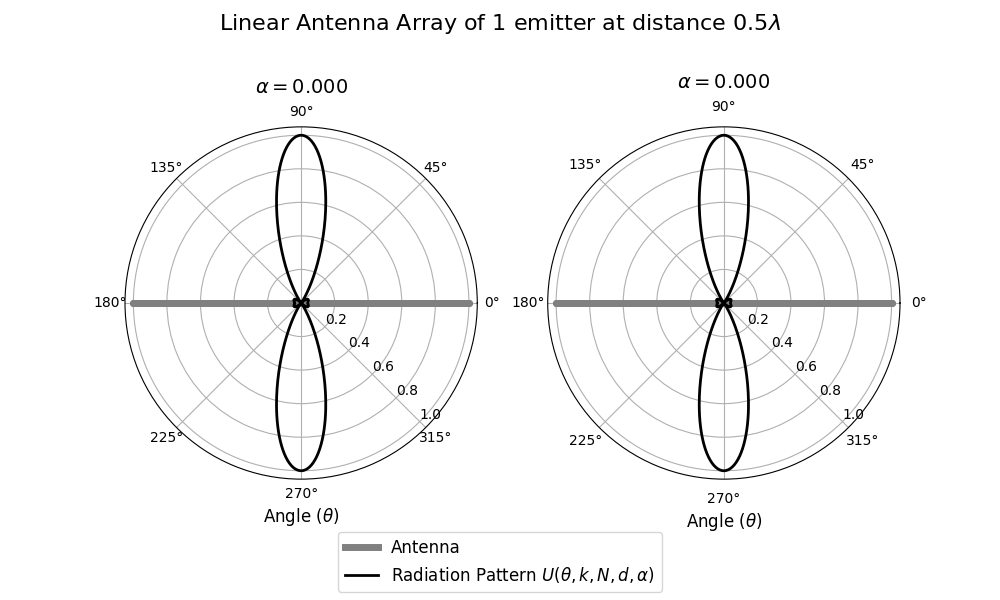

In [3]:
thetas = np.linspace(-np.pi, np.pi, 1000)
wavelength = 0.19 # m, L1-band GPS with f = 1575.42 MHz
number_of_emitters = 1
emitter_phase_offset = 0
emitter_distance = wavelength / 2

pattern = phased_array(thetas, wavelength, number_of_emitters, emitter_phase_offset, emitter_distance)

def antenna_visual(axis, thickness, legend = None):
    thetas = [0, 0, np.pi, np.pi]
    rs = [0, 1, 1, 0]
    ll, = axis.plot(thetas, rs, linewidth = thickness, color = 'grey')
    if legend:
        ll.set_label(legend)

fig = plt.figure(figsize=(10, 6))
fig.suptitle(fr'Linear Antenna Array of {int(number_of_emitters)} emitter at distance {(emitter_distance / wavelength):.1f}$\lambda$', fontsize = 16)

ax = fig.add_subplot(121, projection='polar')
ax.set_title(rf'$\alpha = {emitter_phase_offset:.3f}$', va='bottom', fontsize = 14)
ax.tick_params(axis='both', which='both', direction = 'in', top=True, bottom=True, left=True, right=True)
antenna_visual(ax, 5)
ax.plot(thetas, pattern, linewidth = 2, color = 'black')
ax.set_rlabel_position(315)
ax.set_xlabel(r'Angle ($\theta$)', fontsize = 12)

ax1 = fig.add_subplot(122, projection='polar')
ax1.set_title(rf'$\alpha = {emitter_phase_offset:.3f}$', va='bottom', fontsize = 14)
ax.tick_params(axis='both', which='both', direction = 'in', top=True, bottom=True, left=True, right=True)
antenna_visual(ax1, 5)
ax1.plot(thetas, pattern, linewidth = 2, color = 'black')
ax1.set_rlabel_position(315)
ax1.set_xlabel(r'Angle ($\theta$)', fontsize = 12)


slider_number_of_emitters = FloatSlider(value=1, min=1, max=30, step=1, description = 'N')
slider_emitter_distance = FloatSlider(value = wavelength / 2, min = 0.000, max = 10 * wavelength, step = wavelength / 10, description = 'd')
slider_phase_offset = FloatSlider(value = 0, min = -10.000 * np.pi, max = 10.000 * np.pi, step = np.pi / 8, description = 'alpha')

@interact(number_of_emitters=slider_number_of_emitters, emitter_distance=slider_emitter_distance, emitter_phase_offset = slider_phase_offset)
def update_plot(number_of_emitters, emitter_distance, emitter_phase_offset):
    updated_array = phased_array(thetas, wavelength, number_of_emitters, 0, emitter_distance)
    updated_phase_array = phased_array(thetas, wavelength, number_of_emitters, emitter_phase_offset, emitter_distance)

    ax.clear()
    antenna_visual(ax, 5)
    ax.plot(thetas, updated_array, linewidth = 2, color = 'black')
    ax.set_title(rf'$\alpha = {0:.3f}$', va='bottom', fontsize = 14)
    ax.set_rlabel_position(315)
    ax.set_xlabel(r'Angle ($\theta$)', fontsize = 12)

    ax1.clear()
    antenna_visual(ax1, 5, legend='Antenna')
    ax1.plot(thetas, updated_phase_array, linewidth = 2, color = 'black', label = r'Radiation Pattern $U\left(\theta, k, N, d, \alpha\right)$')
    ax1.set_title(rf'$\alpha = {emitter_phase_offset:.3f}$', va='bottom', fontsize = 14)
    ax1.set_rlabel_position(315)
    ax1.set_xlabel(r'Angle ($\theta$)', fontsize = 12)

    fig.suptitle(fr'Linear Antenna Array of {int(number_of_emitters)} emitter at distance {(emitter_distance / wavelength):.1f}$\lambda$', fontsize = 16)
    fig.legend(loc='lower center', fontsize=12)
    fig.canvas.draw_idle()
